# Übung 1: Backpropagation für Mehrschichtenperzeptronen

In [1]:
import os, sys, importlib, math
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

In [2]:
# Load modules from modules directory
base_path_modules = os.path.join(os.getcwd(), "..", "modules")
sys.path.append(base_path_modules)
import load_mnist
importlib.reload(load_mnist)

<module 'load_mnist' from 'E:\\Users\\Tobias\\Python_Workspace\\DL-WS1920\\notebooks\\..\\modules\\load_mnist.py'>

### 1. Spielzeugdatensatz

Laden Sie sich das Jupyter-Notebook "Training eines MLPs auf MNIST" von der Vorlesungsseite auf Moodle herunter, das den Numpy-Code für den Backpropagation-Agortihmus für den MLPs enthält. Statt auf MNIST werden wir zunächst ein einfacheres Perzeptron auf den Spielzeugdaten aus der Vorlesung trainieren.

#### Vorgehensweise:
1. Erzeugen Sie 200 zweidimensionale Trainingsdatenpunkte mithilfe einer Gleichverteilung über dem Gebiet [-6,6]  x [-6,6]. Speichern Sie diese in einer 200 x 2 Designmatrix.
2. Die Klassenlabels 0 und 1 werden so vergeben, dass alle Datenpunkte im 1. und 3. Quadranten das Label 1 und im 2. und 4. Quadranten das Label 0 erhalten. Speichern Sie die Labels in einem Array.
3. Erzeugen Sie einen gleich großen Testdatensatz nach demselben Prinzip stellen Sie beide Datensätze zur Überprüfung als Scatterplot dar.

In [3]:
# Uniformly distributed training-data over intervall [-6, 6]
x_train = np.random.uniform(-6, 6, (200, 2))
x_train

array([[-1.83403492, -0.13330548],
       [ 2.0123838 ,  0.49609482],
       [-2.57355505, -1.30422289],
       [ 2.55026168,  3.38806205],
       [-3.6819999 , -1.02415446],
       [-0.02020087, -4.29893278],
       [ 2.95650446, -4.44164205],
       [ 2.90244432, -1.56364648],
       [-4.05952421, -5.78779489],
       [-5.55601964,  5.41481452],
       [-4.43344181, -0.94009064],
       [ 4.37512179,  1.16268282],
       [ 4.89194139, -1.7490416 ],
       [ 1.43948868,  4.2468158 ],
       [ 4.49924889, -1.24674418],
       [-1.30788945, -1.13769959],
       [ 3.90640711, -1.05435508],
       [-2.31663568,  3.70111146],
       [ 2.64044064, -2.98386036],
       [ 3.06581763,  4.87097092],
       [ 1.25312977,  1.10412255],
       [-5.92408949, -4.47621569],
       [ 4.60484627, -1.26315436],
       [-4.35359784, -4.43230079],
       [-1.72022093,  1.60095829],
       [ 0.68986893, -2.76204742],
       [ 4.08697441, -4.05828337],
       [-2.23767455, -3.11836414],
       [-3.51471834,

In [4]:
x_train.shape

(200, 2)

In [5]:
x_train.max()

5.942275640523308

In [6]:
x_train.min()

-5.996269733334685

In [7]:
# Create training set labels
check_1d_quad = np.logical_and(x_train.T[0] > 0, x_train.T[1] > 0)
check_3d_quad = np.logical_and(x_train.T[0] < 0, x_train.T[1] < 0)
check_rev = np.logical_or(check_1d_quad, check_3d_quad)
y_train = np.where(check_rev, 1, 0)
y_train

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0])

In [8]:
y_train.shape

(200,)

In [9]:
# stack data into frame
stacked = np.vstack((x_train.T, y_train))
pseudo_data = pd.DataFrame(stacked)
pseudo_data.T.head()

,0,1,2
0,-1.834035,-0.133305,1.0
1,2.012384,0.496095,1.0
2,-2.573555,-1.304223,1.0
3,2.550262,3.388062,1.0
4,-3.682000,-1.024154,1.0


In [10]:
def gen_data(samples = 200):
    """
        Generate uniformly distributed data points over [-6, 6] x [-6, 6] of shape (200, 2)
        
        Parrameter:
        - samples: amount of random samples to generate 
        
        return (data, label)
    """
    x_train = np.random.uniform(-6, 6, (samples, 2))
    
    check_1d_quad = np.logical_and(x_train.T[0] > 0, x_train.T[1] > 0)
    check_3d_quad = np.logical_and(x_train.T[0] < 0, x_train.T[1] < 0)
    check_rev = np.logical_or(check_1d_quad, check_3d_quad)
    y_train = np.where(check_rev, 1, 0)
    
    return (x_train, y_train)

# Put train/test data together into a frame for plotting
def get_frame(train, test):
    return pd.DataFrame(np.vstack((train.T, test)), index = [0, 1, "label"])

def plot_data(frame):
    sns.scatterplot(data = frame.T, x = 0, y = 1, hue = "label")

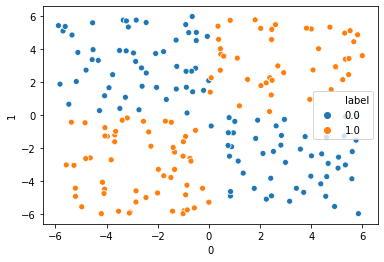

In [11]:
(x_train, y_train) = gen_data()
train_df = get_frame(x_train, y_train)
plot_data(train_df)

In [12]:
train_df.T.describe()

,0,1,label
count,200.000000,200.000000,200.000000
mean,-0.065618,0.069619,0.490000
std,3.375877,3.577958,0.501154
min,-5.883950,-5.968370,0.000000
25%,-2.886697,-2.797815,0.000000
50%,-0.524846,-0.207571,0.000000
75%,2.538675,3.063614,1.000000
max,5.991391,5.991487,1.000000


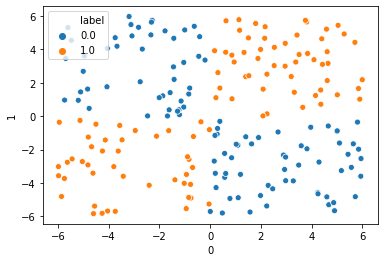

In [13]:
(x_test, y_test) = gen_data()
test_df = get_frame(x_test, y_test)
plot_data(test_df)

In [14]:
test_df.T.describe()

,0,1,label
count,200.000000,200.000000,200.000000
mean,0.282216,0.052387,0.490000
std,3.425763,3.482039,0.501154
min,-5.978874,-5.839398,0.000000
25%,-2.318335,-2.922925,0.000000
50%,0.344665,-0.124522,0.000000
75%,3.215458,3.240192,1.000000
max,5.995261,5.964876,1.000000


4. Das in der Vorlesung dargestellte Experiment operiert nicht direkt auf den Inputdaten, sondern auf 2 Merkmale, die mithilfe zweier neuroren mit fixem Gewichtsvektor berechnet werden: ein Neuron teilt die Inputebene waagrecht entlang der x-Achse, das andere senkrecht entlang der y-Achse. Wie muss der Gewichtsvektor für das jeweilige Neuron aussehen?


- Gewichtvektor erstes Neuron [1,0] (entlang x-achse teilen)
- Gewichtsvektor zweites Neuron [0,1] (entlang y-achse teilen)

5. Berechnen Sie die Entscheidungsfunktion beider Neuronen mit der im Beispielcode angegebenen sigmoiden Aktiviterungsfunktion auf einem 100 x 100 Gitter innerhalb des gebiets [-6, 6]x [-6, 6] und stellen Sie diese zur Überprüfung als Farbbild dar.

In [15]:
sigmoid = lambda x: 1/(1+np.exp(-x))
sigmoid_prime = lambda x: sigmoid(x) + (1- sigmoid(x))

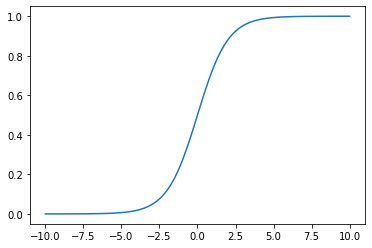

In [16]:
# Sigmoid function
x = np.linspace(-10, 10, 100)
z = sigmoid(x)

plt.plot(x, z)
plt.show()

In [17]:
value_space = np.linspace(-6, 6, 200)
extended_sig = lambda x: sigmoid(np.sqrt(x))
sig_vect = np.vectorize(sigmoid)

In [18]:
def create_grid(dim):
    """
        Create a grid with the given dimensions
    """
    values_direction = np.linspace(-6, 6, dim)
    return np.array(np.meshgrid(values_direction, values_direction)).T.reshape(-1, dim, 2);
    

def calc_activation(weights, activation = sig_vect, shape = (100, 100)):
    """
        Creates an image plot out of given weights.
    
        intput:
         - weights: to use for calculation with dimension (2,)
         - activation: activation function to use in vectorized form
         - shape: shape of grid to be generated
    """
    
    x_dimension, y_dimension = shape
    weights_matrix = np.zeros((x_dimension, 2)) + weights
    
    # Create a grid for calculation
    # values_direction = np.linspace(-6, 6, x_dimension)
    # grid = np.array(np.meshgrid(values_direction, values_direction)).T.reshape(-1, x_dimension, 2)
    
    grid = create_grid(x_dimension)
    
    # Calculate the mse and use sigmoid activation
    weighted_values = grid * weights_matrix # (100, 100, 2)
    summed_values = np.sum(weighted_values, axis = 2) # (100, 100)
    calculated = sig_vect(summed_values) # use activation function on cell values
    return calculated

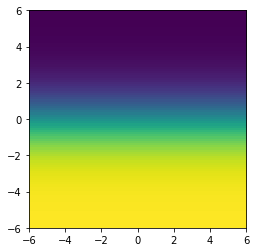

In [19]:
first_neuron_weight = np.array([1, 0])
output_first_neuron = calc_activation(first_neuron_weight)
plt.imshow(output_first_neuron, extent = [-6,6,-6,6]) 

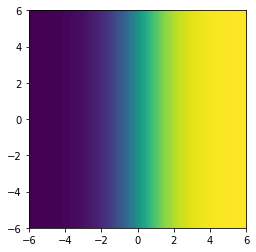

In [20]:
second_neuron_weight = np.array([0,1])
output_sec_neuron = calc_activation(second_neuron_weight)
plt.imshow(output_sec_neuron, extent = [-6,6,-6,6]) 

6. Da die Eingangsneuronen nicht mittrainiert werden, können wir deren Output schon im Vorfeld berechnen. Erzeugen Sie dazu neue Designmatrizen für den Trainings und Testddatensatz, so dass die erste Spalte den Ouput des ersten Neurons und die zweite Spalte den Ouput des zweiten Neurons enhält. Erzeugen Sie auch eine entsprechende Designmatrix für Ihr 100 x 100-Gitter, die wir später zu Darstellungszwecken brauchen werden. Wichtig: arbeiten Sie im Folgenden nur mit diesen transformierten Designmatrizen, um korrekte Ergebenisse zu erhalten!

In [21]:
(x_train, y_train) = gen_data(100)

# Weights for the neurons
weights_first_neuron = np.zeros((100,2)) + np.array([0,1])
weights_second_neuron = np.zeros((100,2)) +np.array([1,0])

# Calculate output values for each neuron
output_first_n = sig_vect(np.sum(x_train * weights_first_neuron, axis = 1))
output_second_n = sig_vect(np.sum(x_train * weights_second_neuron, axis = 1))

In [22]:
output_first_n[:5]

array([0.96649673, 0.82861929, 0.01505254, 0.96885853, 0.97235301])

In [23]:
output_second_n[:5]

array([0.03409322, 0.00537541, 0.99627057, 0.96876727, 0.22936215])

In [24]:
# Concat neuron output values
input_output_layer = np.vstack((output_first_n, output_second_n)).T
input_output_layer.shape

(100, 2)

In [25]:
# first column (=output first neuron), second colum (=output second neuron) 
input_output_layer[:5]

array([[0.96649673, 0.03409322],
       [0.82861929, 0.00537541],
       [0.01505254, 0.99627057],
       [0.96885853, 0.96876727],
       [0.97235301, 0.22936215]])

In [26]:
# Create 100x100 grid
grid = np.zeros((100, 100))
grid.shape

(100, 100)

### 2. Training eines MLPs auf den Spelzeugaten
Der Code aus dem Beispielnotebook muss zunächst an das Szenario aus der Vorlesung angepasst werden: ein deutlich kleineres Netzwerk mit eindimensionalen statt zehndimensioanlem Output.

---
Vorgehensweise:
1. Setzten Sie im Code die Größe der Minibatches auf 10, die Anzahl der Epochen auf 150 und die Lernrate auf 0.03. Ändern Sie die Netzarchitektur so ab, dass sie 2 Eingangsneuronen, 2 verdeckte Schichten mit jeweils 2 Neuronen und 1 Ausgangsneuron haben. Überprüfen Sie die Größen der sich daraus ergebenden Gewichtsmatrizen auf Korrektheit.
2. Der Beispielcode verwendet One-Hot-Coding für die Labels in unserem Beispiel sind die Klassenzugehörigkeiten aber durch die Klassenindizes 0 und 1 codiert. Wir müssen daher die Funktion `evaluate()` im Code so abändern das , das ein Beispiel als korrekt klassifiziert gilt, wenn bei Klasse 0 der MLP-Ouptut kleiner als 0.5 ist und bei Klasse 1 größer als 0.5 Berechnen Sie zusätzlich den MSE in dieser Funktion bei jedem Aufruf und speichern Sie diesen in einem zusätzlichen Array ab.

In [27]:
import mlp
importlib.reload(mlp)

<module 'mlp' from 'E:\\Users\\Tobias\\Python_Workspace\\DL-WS1920\\notebooks\\..\\modules\\mlp.py'>

In [28]:
def plot_stats(acc, loss):
    fig = plt.figure(figsize = (15, 4))
    plt.subplot(121)
    plt.title("Accuracy")
    plt.plot(acc)
    
    plt.subplot(122)
    plt.title("Loss")
    plt.plot(loss)
    
def plot_generalization(trained_mlp, x_train, y_train):
    
    # Create a grid to see generalization
    new_grid = create_grid(100)
    grid_x = new_grid.reshape(100*100, 2) # reshape values so that they are processable by evaluate
    grid_x.shape
    
    results = np.zeros(grid_x.shape[0])
    for j in range(grid_x.shape[0]):
        results[j] = trained_mlp.predict(grid_x[j])

    # Reshape to get plot background
    background_plot = results.reshape(100, 100)
    fig = plt.figure(figsize = (5, 5))
    plot_data(train_df)
    plt.imshow(background_plot, extent = [-6,6,-6,6]) 

In [29]:
# Learning rate .03, epochs = 150, mini-batch 10 
epochs = 150
mbs = 10
eta = 0.03

sizes = [2, 2, 2, 1]

new_mlp = mlp.MLP(sizes, epochs = epochs, mbs = mbs, eta = eta)

(x_train, y_train) = gen_data(200)
(x_test, y_test) = gen_data(100)
(acc, loss) = new_mlp.train(x_train, y_train, x_test, y_test)

++++++++++++++++++
 MLP SETUP 
++++++++++++++++++
 Epochs: 150
 Learning-Rate: 0.03
 Mini-batch-size: 10
------------
 Activation: sigmoid
 Loss: mse
++++++++++++++++++
Epoch 0: 50.0 / 100 [Loss: 0.253]
Epoch 1: 50.0 / 100 [Loss: 0.252]
Epoch 2: 50.0 / 100 [Loss: 0.252]
Epoch 3: 50.0 / 100 [Loss: 0.252]
Epoch 4: 50.0 / 100 [Loss: 0.252]
Epoch 5: 50.0 / 100 [Loss: 0.251]
Epoch 6: 50.0 / 100 [Loss: 0.251]
Epoch 7: 50.0 / 100 [Loss: 0.251]
Epoch 8: 50.0 / 100 [Loss: 0.251]
Epoch 9: 50.0 / 100 [Loss: 0.251]
Epoch 10: 58.0 / 100 [Loss: 0.251]
Epoch 11: 52.0 / 100 [Loss: 0.251]
Epoch 12: 45.0 / 100 [Loss: 0.251]
Epoch 13: 37.0 / 100 [Loss: 0.251]
Epoch 14: 39.0 / 100 [Loss: 0.251]
Epoch 15: 40.0 / 100 [Loss: 0.251]
Epoch 16: 42.0 / 100 [Loss: 0.251]
Epoch 17: 43.0 / 100 [Loss: 0.251]
Epoch 18: 43.0 / 100 [Loss: 0.251]
Epoch 19: 45.0 / 100 [Loss: 0.251]
Epoch 20: 45.0 / 100 [Loss: 0.251]
Epoch 21: 40.0 / 100 [Loss: 0.251]
Epoch 22: 45.0 / 100 [Loss: 0.251]
Epoch 23: 50.0 / 100 [Loss: 0.251]
E

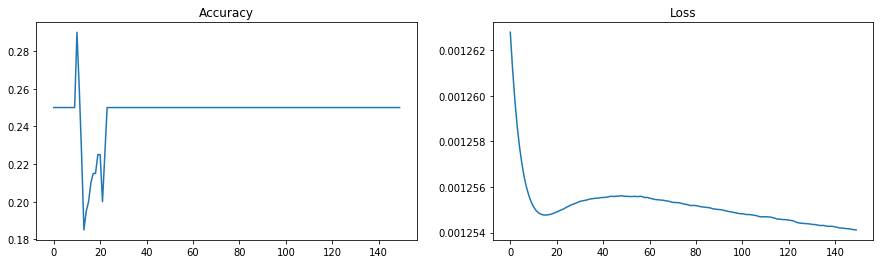

In [30]:
plot_stats(acc / x_train.shape[0], loss / x_train.shape[0])

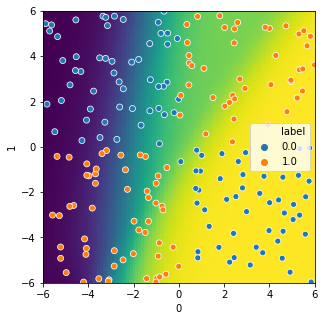

In [31]:
plot_generalization(new_mlp, x_train, y_train)

3. Trainieren Sie Ihr Netz mit den Trainingsdaten als Validierungsdaten und testen Sie es
auf Ihren Testdaten. Stellen Sie die Lernkurven für Genauigkeit und MSE als Plots dar.
Beachten Sie hierbei, dass unser Lernproblem nicht konvex ist, so dass die Optimierung
zuweilen in lokalen Minima hängenbleiben kann. Wiederholen Sie Ihren Versuch daher
mehrere Male und vergeleichen Sie die Ergebnisse.

In [32]:
mbs = 10
epochs = 400
eta = 1.2

# Train network
new_mlp = mlp.MLP(sizes, epochs = epochs, mbs = mbs, eta = eta)
x_train, y_train = gen_data(200)
x_test, y_test = gen_data(100)
(acc, loss) = new_mlp.train(x_train, y_train, x_test, y_test)

++++++++++++++++++
 MLP SETUP 
++++++++++++++++++
 Epochs: 400
 Learning-Rate: 1.2
 Mini-batch-size: 10
------------
 Activation: sigmoid
 Loss: mse
++++++++++++++++++
Epoch 0: 49.0 / 100 [Loss: 0.255]
Epoch 1: 49.0 / 100 [Loss: 0.251]
Epoch 2: 49.0 / 100 [Loss: 0.251]
Epoch 3: 49.0 / 100 [Loss: 0.251]
Epoch 4: 58.0 / 100 [Loss: 0.251]
Epoch 5: 52.0 / 100 [Loss: 0.251]
Epoch 6: 39.0 / 100 [Loss: 0.251]
Epoch 7: 40.0 / 100 [Loss: 0.251]
Epoch 8: 51.0 / 100 [Loss: 0.252]
Epoch 9: 49.0 / 100 [Loss: 0.253]
Epoch 10: 49.0 / 100 [Loss: 0.251]
Epoch 11: 47.0 / 100 [Loss: 0.251]
Epoch 12: 44.0 / 100 [Loss: 0.251]
Epoch 13: 49.0 / 100 [Loss: 0.254]
Epoch 14: 53.0 / 100 [Loss: 0.251]
Epoch 15: 48.0 / 100 [Loss: 0.251]
Epoch 16: 53.0 / 100 [Loss: 0.251]
Epoch 17: 47.0 / 100 [Loss: 0.25]
Epoch 18: 44.0 / 100 [Loss: 0.25]
Epoch 19: 46.0 / 100 [Loss: 0.249]
Epoch 20: 43.0 / 100 [Loss: 0.249]
Epoch 21: 50.0 / 100 [Loss: 0.248]
Epoch 22: 57.0 / 100 [Loss: 0.25]
Epoch 23: 57.0 / 100 [Loss: 0.252]
Epoch

Epoch 231: 65.0 / 100 [Loss: 0.177]
Epoch 232: 68.0 / 100 [Loss: 0.175]
Epoch 233: 66.0 / 100 [Loss: 0.174]
Epoch 234: 65.0 / 100 [Loss: 0.172]
Epoch 235: 69.0 / 100 [Loss: 0.183]
Epoch 236: 66.0 / 100 [Loss: 0.173]
Epoch 237: 65.0 / 100 [Loss: 0.173]
Epoch 238: 65.0 / 100 [Loss: 0.172]
Epoch 239: 62.0 / 100 [Loss: 0.173]
Epoch 240: 68.0 / 100 [Loss: 0.176]
Epoch 241: 66.0 / 100 [Loss: 0.174]
Epoch 242: 63.0 / 100 [Loss: 0.172]
Epoch 243: 66.0 / 100 [Loss: 0.174]
Epoch 244: 64.0 / 100 [Loss: 0.174]
Epoch 245: 68.0 / 100 [Loss: 0.173]
Epoch 246: 61.0 / 100 [Loss: 0.175]
Epoch 247: 64.0 / 100 [Loss: 0.175]
Epoch 248: 65.0 / 100 [Loss: 0.173]
Epoch 249: 70.0 / 100 [Loss: 0.176]
Epoch 250: 70.0 / 100 [Loss: 0.177]
Epoch 251: 55.0 / 100 [Loss: 0.175]
Epoch 252: 68.0 / 100 [Loss: 0.175]
Epoch 253: 65.0 / 100 [Loss: 0.173]
Epoch 254: 65.0 / 100 [Loss: 0.173]
Epoch 255: 68.0 / 100 [Loss: 0.173]
Epoch 256: 69.0 / 100 [Loss: 0.187]
Epoch 257: 65.0 / 100 [Loss: 0.174]
Epoch 258: 66.0 / 100 [Loss:

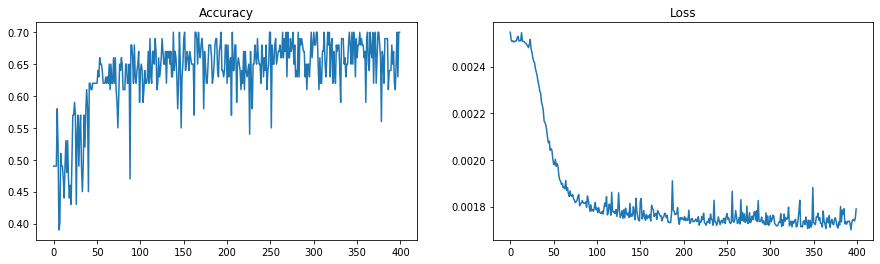

In [33]:
plot_stats(acc/x.shape[0], loss/x.shape[0])

4. Berechnen Sie die Entscheidungsfunktion Ihres MLPs für Ihr 100 × 100-Gitter und
stellen Sie diese gemeinsam mit dem Scatterplot Ihrer Trainingsdaten dar.

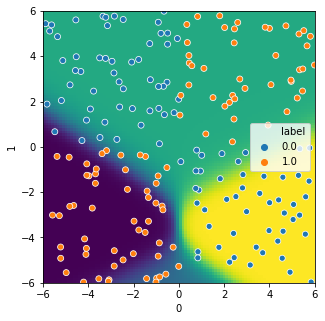

In [34]:
plot_generalization(new_mlp, x_train, y_train)

### 3. Nachvolziehen der Beispiele aus der Vorlesung
Das Netz aus der Vorlesung verwendet als Aktivierungsfuntkion den *Tangens-hyperbolicus* (`np.tanh()`). Passen Sie die Funktion `sigmoid()` und `sigmoid_prime()` entsprechend an. 

**Achtung:** kommentieren Sie den bisherigen Code für die Sigmoidfunktion nur aus, wir werden ihn in der nächsten Aufgabe nochmals benötigen. Da die Ausgangswerte von *tanh* im Intervall [-1,1] statt [0,1] liegen, müsssen wir hierfür nochmals die Funktion `evaluate()` enstsprechend anpassen.

In [35]:
# Parameters
mbs = 10
eta = 1.2
epochs = 150
sizes = [2, 2, 2, 1]

new_mlp = mlp.MLP(sizes, epochs = epochs, mbs = mbs, eta = eta, activation = "tanh")
x_train, y_train = gen_data(200)
x_test, y_test = gen_data(100)
(acc, loss) = new_mlp.train(x_train, y_train, x_test, y_test)

++++++++++++++++++
 MLP SETUP 
++++++++++++++++++
 Epochs: 150
 Learning-Rate: 1.2
 Mini-batch-size: 10
------------
 Activation: tanh
 Loss: mse
++++++++++++++++++
Epoch 0: 41.0 / 100 [Loss: 0.318]
Epoch 1: 66.0 / 100 [Loss: 0.202]
Epoch 2: 93.0 / 100 [Loss: 0.071]
Epoch 3: 97.0 / 100 [Loss: 0.035]
Epoch 4: 97.0 / 100 [Loss: 0.03]
Epoch 5: 96.0 / 100 [Loss: 0.037]


E:\Users\Tobias\Python_Workspace\DL-WS1920\notebooks\..\modules\mlp.py:295: RuntimeWarning: overflow encountered in cosh
  return (1.0 / np.cosh(np.cosh(z)))


Epoch 6: 97.0 / 100 [Loss: 0.029]
Epoch 7: 95.0 / 100 [Loss: 0.039]
Epoch 8: 97.0 / 100 [Loss: 0.027]
Epoch 9: 94.0 / 100 [Loss: 0.039]
Epoch 10: 95.0 / 100 [Loss: 0.045]
Epoch 11: 95.0 / 100 [Loss: 0.03]
Epoch 12: 98.0 / 100 [Loss: 0.02]
Epoch 13: 98.0 / 100 [Loss: 0.022]
Epoch 14: 95.0 / 100 [Loss: 0.033]
Epoch 15: 98.0 / 100 [Loss: 0.019]
Epoch 16: 98.0 / 100 [Loss: 0.017]
Epoch 17: 98.0 / 100 [Loss: 0.018]
Epoch 18: 98.0 / 100 [Loss: 0.019]
Epoch 19: 96.0 / 100 [Loss: 0.031]
Epoch 20: 98.0 / 100 [Loss: 0.018]
Epoch 21: 98.0 / 100 [Loss: 0.015]
Epoch 22: 98.0 / 100 [Loss: 0.014]
Epoch 23: 98.0 / 100 [Loss: 0.015]
Epoch 24: 98.0 / 100 [Loss: 0.013]
Epoch 25: 97.0 / 100 [Loss: 0.021]
Epoch 26: 95.0 / 100 [Loss: 0.026]
Epoch 27: 98.0 / 100 [Loss: 0.022]
Epoch 28: 98.0 / 100 [Loss: 0.018]
Epoch 29: 98.0 / 100 [Loss: 0.012]
Epoch 30: 98.0 / 100 [Loss: 0.013]
Epoch 31: 98.0 / 100 [Loss: 0.013]
Epoch 32: 98.0 / 100 [Loss: 0.013]
Epoch 33: 95.0 / 100 [Loss: 0.037]
Epoch 34: 95.0 / 100 [Loss

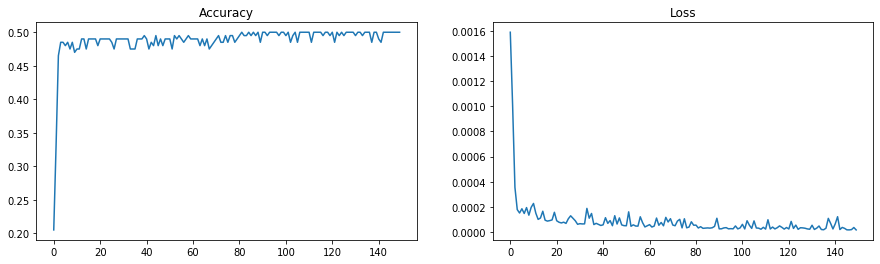

In [36]:
plot_stats(acc/x_train.shape[0], loss/x_train.shape[0])

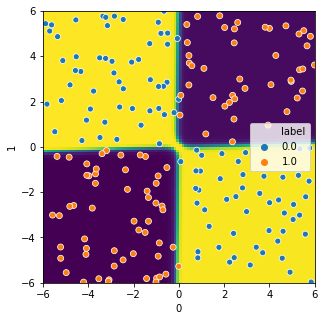

In [37]:
plot_generalization(new_mlp, x_train, y_train)

Vollziehen Sie die 3 Beispiele aus der Vorlesung nach.

### 4. Logistische Regression
Eine alternative, besser an das Klassifikationsszenario angepasst Kostenfunktion statt des MSE ist die Kostenfunktion für die logisitische Regression: 

$C$ = -*y* log($a^l$) - (1 - *y*) log(1 - $a^l$)

Damit Sie diese in Ihrem Beispiel anweden können, müssen Sie die Ableitung $\nabla$<sub>$a^L$</sub>$C$ berechnen und die Funktion `cost_derivative()` entsprechend abändern. Da die logistische Regression davon ausgeht, dass der Output des Netzes eine Wahrscheinlichkeit zwischen 0 und 1 ist, können wir hierfür nicht den `tanh()` als Aktivierungsfunktion verwenden. Machen Sie daher Ihre Änderungen aus Aufgabe 3 rückgängig, so dass Sie wieder eine sigmoide Aktivierungsfunktion haben. In der Funktion `evaluate()` sollte natürlich statt des MSE die Kostenfunktion der logistischen Regression ausgegeben werden, um zu überprüfen ob tatsächlich ein Gradientenabstieg stattfindet. Weiterhin ist es nützlich, sowohl auf $C$ wie auf $\nabla$<sub>$a_{L}$</sub>$C$ die Funktion `np.nan_to_num()` anzuwenden, da hier zuweilen numerische Probleme auftreten können.

In [43]:
mbs = 25
eta = 1.0
epochs = 1500
sizes = [2, 2, 2, 1]

In [44]:
log_reg_mlp = mlp.MLP(sizes, epochs = epochs, mbs = mbs, eta = eta, loss ="logreg")

In [45]:
x_train, y_train = gen_data(200)
x_test, y_test = gen_data(100)
(acc, loss) = log_reg_mlp.train(x_train, y_train, x_test, y_test)

++++++++++++++++++
 MLP SETUP 
++++++++++++++++++
 Epochs: 1500
 Learning-Rate: 1.0
 Mini-batch-size: 25
------------
 Activation: sigmoid
 Loss: logreg
++++++++++++++++++
Epoch 0: 49.0 / 100 [Loss: 0.71]
Epoch 1: 49.0 / 100 [Loss: 0.712]
Epoch 2: 49.0 / 100 [Loss: 0.725]
Epoch 3: 49.0 / 100 [Loss: 0.694]
Epoch 4: 49.0 / 100 [Loss: 0.71]
Epoch 5: 72.0 / 100 [Loss: 0.676]
Epoch 6: 73.0 / 100 [Loss: 0.673]
Epoch 7: 61.0 / 100 [Loss: 0.669]
Epoch 8: 73.0 / 100 [Loss: 0.668]
Epoch 9: 60.0 / 100 [Loss: 0.676]
Epoch 10: 72.0 / 100 [Loss: 0.667]
Epoch 11: 59.0 / 100 [Loss: 0.677]
Epoch 12: 72.0 / 100 [Loss: 0.658]
Epoch 13: 61.0 / 100 [Loss: 0.675]
Epoch 14: 72.0 / 100 [Loss: 0.659]
Epoch 15: 71.0 / 100 [Loss: 0.661]
Epoch 16: 71.0 / 100 [Loss: 0.665]
Epoch 17: 73.0 / 100 [Loss: 0.634]
Epoch 18: 73.0 / 100 [Loss: 0.628]
Epoch 19: 73.0 / 100 [Loss: 0.625]
Epoch 20: 72.0 / 100 [Loss: 0.634]
Epoch 21: 73.0 / 100 [Loss: 0.617]
Epoch 22: 72.0 / 100 [Loss: 0.663]
Epoch 23: 73.0 / 100 [Loss: 0.606]


Epoch 228: 98.0 / 100 [Loss: 0.09]
Epoch 229: 98.0 / 100 [Loss: 0.077]
Epoch 230: 98.0 / 100 [Loss: 0.088]
Epoch 231: 98.0 / 100 [Loss: 0.084]
Epoch 232: 98.0 / 100 [Loss: 0.076]
Epoch 233: 99.0 / 100 [Loss: 0.049]
Epoch 234: 98.0 / 100 [Loss: 0.058]
Epoch 235: 99.0 / 100 [Loss: 0.054]
Epoch 236: 98.0 / 100 [Loss: 0.088]
Epoch 237: 98.0 / 100 [Loss: 0.079]
Epoch 238: 98.0 / 100 [Loss: 0.077]
Epoch 239: 98.0 / 100 [Loss: 0.077]
Epoch 240: 99.0 / 100 [Loss: 0.05]
Epoch 241: 99.0 / 100 [Loss: 0.053]
Epoch 242: 98.0 / 100 [Loss: 0.061]
Epoch 243: 98.0 / 100 [Loss: 0.095]
Epoch 244: 98.0 / 100 [Loss: 0.058]
Epoch 245: 98.0 / 100 [Loss: 0.092]
Epoch 246: 98.0 / 100 [Loss: 0.094]
Epoch 247: 99.0 / 100 [Loss: 0.053]
Epoch 248: 99.0 / 100 [Loss: 0.052]
Epoch 249: 98.0 / 100 [Loss: 0.077]
Epoch 250: 98.0 / 100 [Loss: 0.087]
Epoch 251: 99.0 / 100 [Loss: 0.054]
Epoch 252: 98.0 / 100 [Loss: 0.079]
Epoch 253: 98.0 / 100 [Loss: 0.092]
Epoch 254: 98.0 / 100 [Loss: 0.085]
Epoch 255: 99.0 / 100 [Loss: 0

Epoch 456: 98.0 / 100 [Loss: 0.093]
Epoch 457: 98.0 / 100 [Loss: 0.099]
Epoch 458: 98.0 / 100 [Loss: 0.095]
Epoch 459: 98.0 / 100 [Loss: 0.085]
Epoch 460: 99.0 / 100 [Loss: 0.047]
Epoch 461: 98.0 / 100 [Loss: 0.102]
Epoch 462: 98.0 / 100 [Loss: 0.07]
Epoch 463: 98.0 / 100 [Loss: 0.079]
Epoch 464: 98.0 / 100 [Loss: 0.08]
Epoch 465: 99.0 / 100 [Loss: 0.048]
Epoch 466: 98.0 / 100 [Loss: 0.083]
Epoch 467: 98.0 / 100 [Loss: 0.067]
Epoch 468: 98.0 / 100 [Loss: 0.099]
Epoch 469: 99.0 / 100 [Loss: 0.05]
Epoch 470: 99.0 / 100 [Loss: 0.048]
Epoch 471: 98.0 / 100 [Loss: 0.074]
Epoch 472: 99.0 / 100 [Loss: 0.049]
Epoch 473: 98.0 / 100 [Loss: 0.094]
Epoch 474: 98.0 / 100 [Loss: 0.069]
Epoch 475: 98.0 / 100 [Loss: 0.09]
Epoch 476: 99.0 / 100 [Loss: 0.047]
Epoch 477: 98.0 / 100 [Loss: 0.099]
Epoch 478: 98.0 / 100 [Loss: 0.093]
Epoch 479: 98.0 / 100 [Loss: 0.093]
Epoch 480: 98.0 / 100 [Loss: 0.054]
Epoch 481: 99.0 / 100 [Loss: 0.047]
Epoch 482: 99.0 / 100 [Loss: 0.044]
Epoch 483: 98.0 / 100 [Loss: 0.0

Epoch 686: 98.0 / 100 [Loss: 0.096]
Epoch 687: 99.0 / 100 [Loss: 0.056]
Epoch 688: 99.0 / 100 [Loss: 0.054]
Epoch 689: 98.0 / 100 [Loss: 0.095]
Epoch 690: 98.0 / 100 [Loss: 0.077]
Epoch 691: 98.0 / 100 [Loss: 0.073]
Epoch 692: 99.0 / 100 [Loss: 0.052]
Epoch 693: 98.0 / 100 [Loss: 0.091]
Epoch 694: 98.0 / 100 [Loss: 0.1]
Epoch 695: 99.0 / 100 [Loss: 0.053]
Epoch 696: 98.0 / 100 [Loss: 0.105]
Epoch 697: 99.0 / 100 [Loss: 0.051]
Epoch 698: 98.0 / 100 [Loss: 0.105]
Epoch 699: 98.0 / 100 [Loss: 0.073]
Epoch 700: 99.0 / 100 [Loss: 0.055]
Epoch 701: 98.0 / 100 [Loss: 0.074]
Epoch 702: 99.0 / 100 [Loss: 0.05]
Epoch 703: 98.0 / 100 [Loss: 0.096]
Epoch 704: 98.0 / 100 [Loss: 0.081]
Epoch 705: 98.0 / 100 [Loss: 0.086]
Epoch 706: 99.0 / 100 [Loss: 0.046]
Epoch 707: 98.0 / 100 [Loss: 0.062]
Epoch 708: 98.0 / 100 [Loss: 0.064]
Epoch 709: 98.0 / 100 [Loss: 0.07]
Epoch 710: 98.0 / 100 [Loss: 0.067]
Epoch 711: 98.0 / 100 [Loss: 0.063]
Epoch 712: 99.0 / 100 [Loss: 0.045]
Epoch 713: 99.0 / 100 [Loss: 0.0

Epoch 915: 98.0 / 100 [Loss: 0.078]
Epoch 916: 98.0 / 100 [Loss: 0.081]
Epoch 917: 98.0 / 100 [Loss: 0.085]
Epoch 918: 99.0 / 100 [Loss: 0.053]
Epoch 919: 98.0 / 100 [Loss: 0.089]
Epoch 920: 98.0 / 100 [Loss: 0.097]
Epoch 921: 99.0 / 100 [Loss: 0.047]
Epoch 922: 99.0 / 100 [Loss: 0.044]
Epoch 923: 98.0 / 100 [Loss: 0.058]
Epoch 924: 98.0 / 100 [Loss: 0.055]
Epoch 925: 98.0 / 100 [Loss: 0.095]
Epoch 926: 98.0 / 100 [Loss: 0.064]
Epoch 927: 98.0 / 100 [Loss: 0.064]
Epoch 928: 99.0 / 100 [Loss: 0.047]
Epoch 929: 98.0 / 100 [Loss: 0.087]
Epoch 930: 98.0 / 100 [Loss: 0.063]
Epoch 931: 99.0 / 100 [Loss: 0.046]
Epoch 932: 98.0 / 100 [Loss: 0.058]
Epoch 933: 98.0 / 100 [Loss: 0.069]
Epoch 934: 98.0 / 100 [Loss: 0.067]
Epoch 935: 99.0 / 100 [Loss: 0.044]
Epoch 936: 98.0 / 100 [Loss: 0.078]
Epoch 937: 98.0 / 100 [Loss: 0.054]
Epoch 938: 98.0 / 100 [Loss: 0.089]
Epoch 939: 98.0 / 100 [Loss: 0.091]
Epoch 940: 99.0 / 100 [Loss: 0.041]
Epoch 941: 98.0 / 100 [Loss: 0.095]
Epoch 942: 98.0 / 100 [Loss:

Epoch 1141: 98.0 / 100 [Loss: 0.099]
Epoch 1142: 98.0 / 100 [Loss: 0.094]
Epoch 1143: 98.0 / 100 [Loss: 0.085]
Epoch 1144: 99.0 / 100 [Loss: 0.049]
Epoch 1145: 99.0 / 100 [Loss: 0.051]
Epoch 1146: 99.0 / 100 [Loss: 0.05]
Epoch 1147: 99.0 / 100 [Loss: 0.051]
Epoch 1148: 99.0 / 100 [Loss: 0.055]
Epoch 1149: 99.0 / 100 [Loss: 0.05]
Epoch 1150: 99.0 / 100 [Loss: 0.051]
Epoch 1151: 99.0 / 100 [Loss: 0.051]
Epoch 1152: 98.0 / 100 [Loss: 0.09]
Epoch 1153: 99.0 / 100 [Loss: 0.051]
Epoch 1154: 98.0 / 100 [Loss: 0.093]
Epoch 1155: 99.0 / 100 [Loss: 0.052]
Epoch 1156: 98.0 / 100 [Loss: 0.099]
Epoch 1157: 99.0 / 100 [Loss: 0.054]
Epoch 1158: 99.0 / 100 [Loss: 0.052]
Epoch 1159: 99.0 / 100 [Loss: 0.054]
Epoch 1160: 98.0 / 100 [Loss: 0.114]
Epoch 1161: 98.0 / 100 [Loss: 0.083]
Epoch 1162: 98.0 / 100 [Loss: 0.09]
Epoch 1163: 98.0 / 100 [Loss: 0.098]
Epoch 1164: 98.0 / 100 [Loss: 0.084]
Epoch 1165: 98.0 / 100 [Loss: 0.072]
Epoch 1166: 98.0 / 100 [Loss: 0.099]
Epoch 1167: 99.0 / 100 [Loss: 0.06]
Epoch 

Epoch 1363: 98.0 / 100 [Loss: 0.063]
Epoch 1364: 98.0 / 100 [Loss: 0.075]
Epoch 1365: 98.0 / 100 [Loss: 0.092]
Epoch 1366: 98.0 / 100 [Loss: 0.094]
Epoch 1367: 98.0 / 100 [Loss: 0.072]
Epoch 1368: 98.0 / 100 [Loss: 0.051]
Epoch 1369: 98.0 / 100 [Loss: 0.053]
Epoch 1370: 98.0 / 100 [Loss: 0.077]
Epoch 1371: 99.0 / 100 [Loss: 0.041]
Epoch 1372: 99.0 / 100 [Loss: 0.04]
Epoch 1373: 99.0 / 100 [Loss: 0.038]
Epoch 1374: 98.0 / 100 [Loss: 0.089]
Epoch 1375: 98.0 / 100 [Loss: 0.095]
Epoch 1376: 98.0 / 100 [Loss: 0.052]
Epoch 1377: 99.0 / 100 [Loss: 0.042]
Epoch 1378: 98.0 / 100 [Loss: 0.092]
Epoch 1379: 98.0 / 100 [Loss: 0.093]
Epoch 1380: 98.0 / 100 [Loss: 0.09]
Epoch 1381: 99.0 / 100 [Loss: 0.041]
Epoch 1382: 98.0 / 100 [Loss: 0.097]
Epoch 1383: 98.0 / 100 [Loss: 0.061]
Epoch 1384: 98.0 / 100 [Loss: 0.057]
Epoch 1385: 98.0 / 100 [Loss: 0.08]
Epoch 1386: 99.0 / 100 [Loss: 0.037]
Epoch 1387: 99.0 / 100 [Loss: 0.04]
Epoch 1388: 99.0 / 100 [Loss: 0.046]
Epoch 1389: 98.0 / 100 [Loss: 0.092]
Epoch

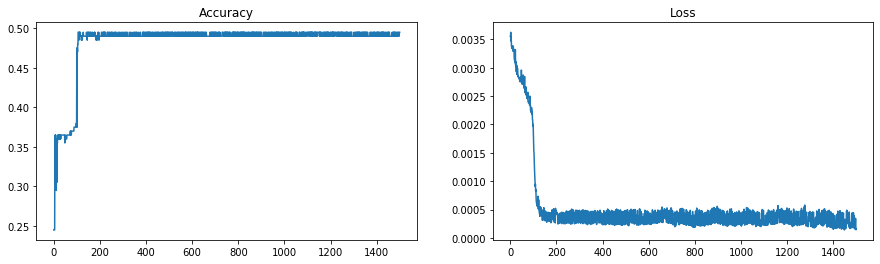

In [46]:
plot_stats(acc / x_train.shape[0], loss / x_train.shape[0])

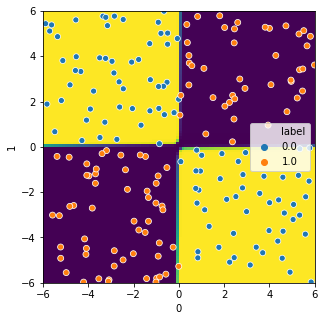

In [47]:
plot_generalization(log_reg_mlp, x_train, y_train)